In [105]:
# Initialization

import pandas as pd
import os
import json

%matplotlib inline
pd.set_option('display.mpl_style', 'default') 
pd.set_option('display.line_width', 5000) 
pd.set_option('display.max_columns', 60)

DATA_PATH = "../data/yellow_sample_001.csv"
OUTPUT_PATH = "../heatmap-visualizer/maps"

# Dataset: 0.1% Sample

Load data:

In [106]:
data = pd.read_csv(DATA_PATH,
                   parse_dates=["Trip_Pickup_DateTime", "Trip_Dropoff_DateTime"],
                   index_col="Trip_Pickup_DateTime")

Clean data:

In [107]:
data = data[(data["Start_Lon"] >= -80) & (data["Start_Lon"] <= -70)]
data = data[(data["Start_Lat"] >= 40) & (data["Start_Lat"] <= 50)]

Augment data with useful attributes:

In [108]:
data["Weekday"] = data.index.weekday
data["Year"] = data.index.year
data["Month"] = data.index.month
data["Hour"] = data.index.hour

Discretize Latitute & Longitudes:

In [109]:
ROUND_PARAM = 3
DISCRETIZED_COLUMN_NAMES = ["Start_Lon_discretized", "Start_Lat_discretized"]

data["Start_Lon_discretized"] = data["Start_Lon"].round(ROUND_PARAM)
data["Start_Lat_discretized"] = data["Start_Lat"].round(ROUND_PARAM)

## Helper Methods

In [110]:
def make_json(counts, title):
    points = []
    for i in range(len(counts)):
        lon, lat = counts.index[i]
        count = counts[i]
        points.append({"lat": lat, "lon": lon, "weight": float(count) / counts.max()})
    
    return {
        "title": title,
        "pointRadius": 10,
        "data": points
    }

## Average Pickup Count

In [111]:
counts = data[DISCRETIZED_COLUMN_NAMES].groupby(DISCRETIZED_COLUMN_NAMES).aggregate(len)
counts = counts[counts > 100]

Count stats

In [112]:
len(counts)

2232

In [113]:
counts.max()

5464

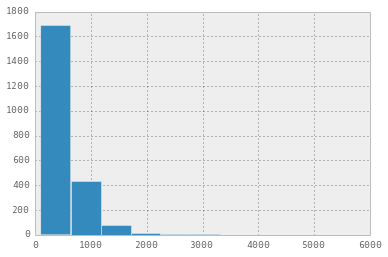

In [114]:
counts.hist()

Save Data to JSON

In [115]:
with open(os.path.join(OUTPUT_PATH, "average_pickup_count.json"), "w") as outfile:
    json.dump(make_json(counts, "Average Pickup Count"), outfile)

## Average Pickup Count By Weekday

In [116]:
columns = ["Weekday"] + DISCRETIZED_COLUMN_NAMES
counts = data[columns].groupby(columns).aggregate(len)
counts = counts[counts > 100]

In [117]:
counts.max()

864

In [118]:
output_dir = os.path.join(OUTPUT_PATH, "average_pickup_count_by_weekday")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

weekday_names = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

for weekday in range(7):
    with open(os.path.join(output_dir, str(weekday) + ".json"), "w") as outfile:
        json.dump(make_json(counts[weekday], weekday_names[weekday]), outfile)